In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython import display

from pydub import AudioSegment

from scipy.signal.windows import hamming
from scipy.signal import spectrogram, find_peaks, detrend

# set png background color to white so they are nicely rendered in the web
plt.rcParams['figure.facecolor'] = 'white'


## Data loading

In [2]:
recording = AudioSegment.from_mp3("../data/2022-08-06_1611.mp3")
recording_mono = recording.set_channels(1) # convert to mono
sampling_rate = recording.frame_rate # in Hz

# drop first 30 seconds and then take 15 minutes
start = 31 # in s
end = 931 # in s
delta = end-start

chunk_size = 2048 # for processing

sample_mono = recording_mono[start*1000:end*1000] # takes t in ms
sample_array = np.array(sample_mono.get_array_of_samples()) # turn into numpy array

## Exploratory spectrogram

An initial look at the data using `matplolib`'s spectrogram (i.e. rolling Fourier Transform) reveals the frequency components in the audio. A Hamming window is used for smoothing. The spectrum was empty > 10 kHz - 20 kHz, so the range in the figure is set to 0-10000 Hz 

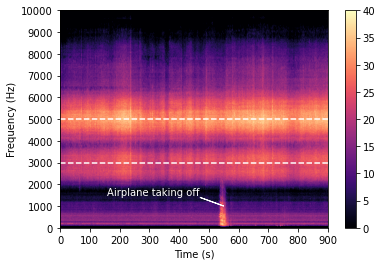

In [3]:
plt.specgram(
    sample_array,
    Fs=sampling_rate,
    NFFT=chunk_size,
    window=hamming(chunk_size),
    mode="psd",
    vmin=0,
    vmax=40,
    cmap="magma",
)
plt.hlines([5000, 3000], 0, delta, colors="white", linestyles=["--", "--"])
plt.colorbar()

plt.yticks(np.arange(0, 10001, 1000));
plt.xticks(np.arange(0, delta+1, 100));

plt.xlim(0, delta);
plt.ylim(0, 10000);

plt.xlabel("Time (s)");
plt.ylabel("Frequency (Hz)");

plt.arrow(550, 1000, -80, 400, color="white");
plt.text(470, 1400, "Airplane taking off", ha="right", va="bottom", color="white");

We see a continuous and broad maximum centered around 5 $\pm$ 1 kHz and a secondary maximum at ~3 $\pm$ 1 kHz. There is no apparent drift in frequency. Some kind of modulation of both signals is already appreciable in the form of vertical patterns. We are looking at the song of the cicadas!

There is a faint low frequency band > 1 kHz that suddenly spikes and stretches up to 2 kHz at ~520 seconds: it is an airplane taking of from the nearby airport, at around 10 km. Fortunately, it seems that the main cicada frequency at 5 kHz is not affected by that interference, so the whole audio sample is used analyze the modulation of the main signal at ~5 kHz.     

In [4]:
# do the same as above but with scipy, so we get a numpy array we can manipulate
f, t, s = spectrogram(
    sample_array, sampling_rate, nfft=chunk_size, window=hamming(chunk_size), mode="psd"
)

fmax_mean_index = np.argmax(s.mean(axis=1))
fmax_mean = f[fmax_mean_index]
fmax_std = f[
    np.argmax(s[fmax_mean_index - 10 : fmax_mean_index + 10], axis=0)
].std()  # allow some tolerance to find the max in each chunk but stay around the mean

print(f"Main frequency is {fmax_mean:.1f} +- {fmax_std:.1f} Hz")

resolution = sampling_rate / chunk_size

print(f"Spectral resolution with {chunk_size} point chunks is {resolution:.1f} Hz/point")


Main frequency is 4921.9 +- 120.4 Hz
Spectral resolution with 2048 point chunks is 23.4 Hz/point


Now that we identified the position and variability of the main signal, we plot it over the averaged spectrum of the audio sample.

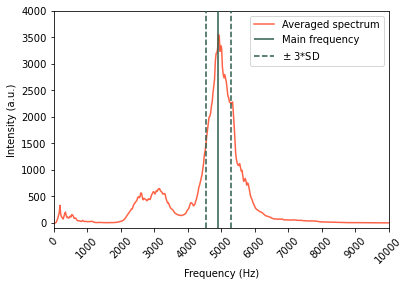

In [5]:
ymin = -100
ymax = 4000

fmax_lower = fmax_mean - 3*fmax_std
fmax_higher = fmax_mean + 3*fmax_std

plt.plot(f, s.mean(axis=1), color="tomato")
plt.vlines(fmax_mean, ymin, ymax, colors="#2B5B47", linestyles="-", zorder=10)
plt.vlines(
    [fmax_lower, fmax_higher],
    ymin,
    ymax,
    colors="#2B5B47",
    zorder=10,
    linestyles="--",
)
plt.xlim(0, 10_000);
plt.xticks(np.arange(0, 10_000+1, 1000), rotation=45);
plt.ylim(ymin, ymax);
plt.xlabel("Frequency (Hz)");
plt.ylabel("Intensity (a.u.)");
plt.legend(["Averaged spectrum", "Main frequency", "$\pm$ 3*SD"]);

## Data processing

In order to reduce noise and ensure we are always catching the bulk of the signal of interest, I will integrate the are between $\pm 3$ standard deviations around the mean maximum and process its evolution with a smaller Hamming window to retain more detail. 

So, I will end with the time evolution of the loudness of the cicada's main tone. 

In [6]:
# integrate signal around fmax_mean +/- 3*fmax_std
fmax_int = s[(f > fmax_lower) & (f < fmax_higher)].sum(axis=0)

# process the integrated signal with a hamming window
filter = hamming(256)
fmax_int_proc = np.convolve(filter/filter.sum(), fmax_int, mode="same")

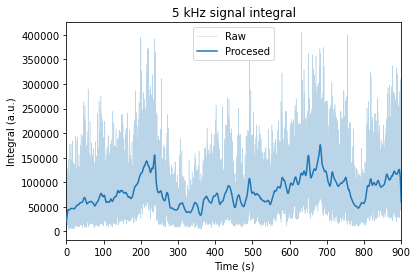

In [7]:
plt.plot(t, fmax_int, linewidth=0.5, alpha=0.3)
plt.plot(t, fmax_int_proc, linewidth=1.5, color="C0", zorder=5)
plt.xticks(np.arange(0, delta+1, 100));
plt.xlim(0, delta);
plt.xlabel("Time (s)")
plt.ylabel("Integral (a.u.)")
plt.title("5 kHz signal integral");

plt.legend(["Raw", "Procesed"]);

We see how the windowing does a good job at de-noising the trajectory of the integrated signal. Still, a slight monotonic increase becomes now evident, which obscures the periodic oscillations. I use a simple linear regression to de-trend the signal integral.

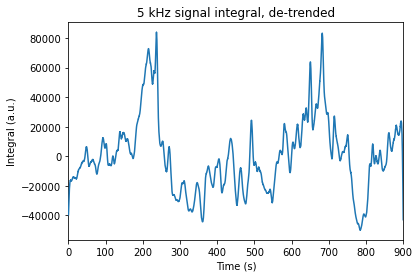

In [8]:
# detrend the signal with a linear regression
fmax_int_proc_detrend = detrend(fmax_int_proc, type="linear")

plt.plot(t, fmax_int_proc_detrend, linewidth=1.5, color="C0", zorder=5)

plt.xticks(np.arange(0, delta+1, 100));
plt.xlim(0, delta);
plt.xlabel("Time (s)")
plt.ylabel("Integral (a.u.)")
plt.title("5 kHz signal integral, de-trended");


So there it is, the pattern I was curious about! It seems that cicadas go really lod and suddenly quiet every ~ seconds, with some rhythmic variations in between. Let's simply put that in numbers by the distances between maxima

## Analysis

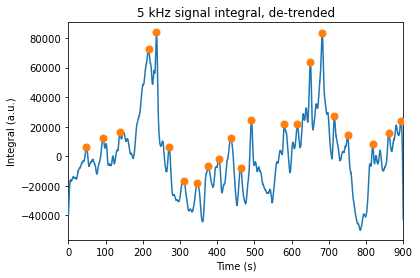

In [9]:
# find peaks in the de-trended signal
peak_indices, _ = find_peaks(fmax_int_proc_detrend, prominence=1e4)
peak_times = t[peak_indices]
peak_values = fmax_int_proc_detrend[peak_indices]

plt.plot(peak_times, peak_values, "o", color="C1", zorder=10, markersize=7)
plt.plot(t, fmax_int_proc_detrend, linewidth=1.5, color="C0", zorder=5)

plt.xticks(np.arange(0, delta+1, 100));
plt.xlim(0, delta);
plt.xlabel("Time (s)")
plt.ylabel("Integral (a.u.)")
plt.title("5 kHz signal integral, de-trended");

In [10]:
# calculate median distance between peaks
peak_distances = np.diff(peak_times)
print(
    f"Median peak distance is {np.median(peak_distances):.0f} s -> {1/np.median(peak_distances):.3f} Hz"
)

# calculate distance between two tallest peaks
peak_times_sorted = peak_times[np.argsort(peak_values)]
peak_distance_tallest = np.abs(np.diff(peak_times_sorted[-2:])[0])
print(
    f"Distance between two tallest peaks is {peak_distance_tallest:.0f} s -> {1/peak_distance_tallest:.3f} Hz"
)


Median peak distance is 35 s -> 0.029 Hz
Distance between two tallest peaks is 446 s -> 0.002 Hz


In a simple approximation I know now that the whole ensemble of cicadas around me (maybe thousands of them) was singing moderately up and down with a period of ~35 seconds. Every ~7 minutes, they would go really loud for about a minute to suddenly go quieter and start over.

Finally, the former NMR spectroscopist in me wanted to do another Fourier Transform and see the frequencies present in this loudness modulation. Although these were near zero and not nicely resolved, the spectrum brought another interesting feature. 

Spectral resolution with 256 point chunks is 0.105 Hz/point


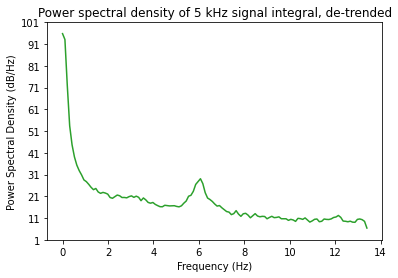

In [11]:
plt.psd(
    fmax_int_proc_detrend,
    NFFT=256,
    window=None,
    Fs=(t.size / delta),
    color="C2",
    detrend=None,
)

resolution = (t.size / delta) / 256
print(f"Spectral resolution with 256 point chunks is {resolution:.3f} Hz/point")

plt.grid(False);
plt.xlabel("Frequency (Hz)");
plt.title("Power spectral density of 5 kHz signal integral, de-trended");


The two modulations commented before peak very close to zero and resolution is not enough to distinguish them. However there is another weaker signal centered around 6 Hz in the PSD plot. This modulation was not evident when analyzing the whole 15 minutes of the integrated signal, but let's zoom in to the seconds.

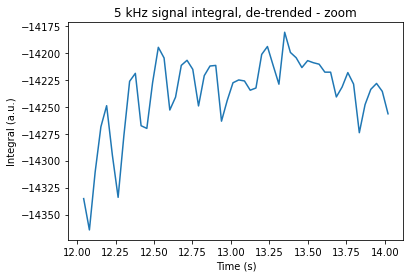

In [12]:
x0 = 322
x1 = 376

plt.plot(t[x0:x1], fmax_int_proc_detrend[x0:x1], linewidth=1.5, color="C0", zorder=5)

plt.xlabel("Time (s)")
plt.ylabel("Integral (a.u.)")
plt.title("5 kHz signal integral, de-trended - zoom");


There it is! I think this corresponds to the constant rhythm of the cicada's chirping, because it matches the order of magnitude -- i.e. a few chirps per second.